In [3]:
#pip install pyproj

Radius used in KM:  0.41282987896593104 equivalent to degrees: 0.0037126682972287626


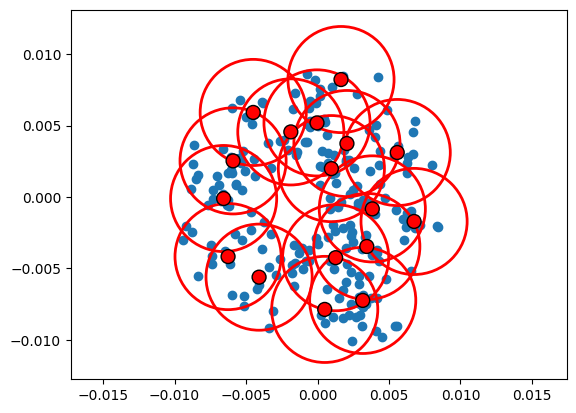

In [4]:
from sklearn import manifold
import scipy
from matplotlib import pyplot as plt
import numpy as np
from pyproj import Transformer
import geopy.distance
import random
import math

transformer = Transformer.from_crs('epsg:3857', 'epsg:4326')

def cartesian_to_geo(x, y):
    return transformer.transform(x, y)

def to_km_distance(coords):
    size = len(coords) # No of nodes
    distances = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            distances[i, j] = geopy.distance.geodesic(coords[i], coords[j]).km # ??
    return distances

def km_to_deg(d):
    earth_radius = 6371
    return 180 * d / (np.pi * earth_radius)

def delay_to_geo(delay_matrix): # Establish the coordinates of each server according to the delay matrix
    size = len(delay_matrix) # No of nodes
    mds_model = manifold.MDS(n_components=2, random_state=0, dissimilarity='precomputed', normalized_stress="auto") # MDS(dissimilarity='precomputed', normalized_stress='auto', random_state=0)
    mds_model.fit(delay_matrix)
    coords = mds_model.fit_transform(delay_matrix) # [[-711.64291427 -379.86399722][..][..]]
    for i in range(size):
        coords[i] = cartesian_to_geo(*coords[i]) # [[-0.0034123763 -0.0063927971][..][..]]

    return coords

def get_radius(coords, scale_factor = 0.9): # The greater the scale_factor the higher the intersection between the nodes
    size = len(delay_matrix) # No of nodes
    node_rad_scale_factor = math.sqrt(math.sqrt(size)) / scale_factor 
    distances = to_km_distance(coords)
    distances = np.tril(distances, k=0) # distance in km between the nodes
    average_distance = np.sum(distances)/((size*size)/2-size/2)
    km_radius = average_distance/node_rad_scale_factor
    deg_radius = km_to_deg(km_radius)
    return km_radius, deg_radius

def place_users_close_to_nodes(users: int, node_coords):
    size = len(node_coords)
    user_coords = []
    radius = get_radius(node_coords)[1]
    for i in range(users):
        node_coord = node_coords[random.choice(range(size))]
        user_coord = []
        alpha = 2 * math.pi * random.random()
        r = radius * random.random()
        user_coord.append(node_coord[0] + r*math.cos(alpha))
        user_coord.append(node_coord[1] + r*math.sin(alpha))
        user_coords.append(user_coord)
    return np.array(user_coords)

def plot(node_coords, user_coords):
    size = len(node_coords)
    colors = ['r'] * size
    sizes = [100] * size
    ax = plt.gca()

    ax.axis("equal")
    radius = get_radius(node_coords)[1]
    plt.scatter(user_coords[:,0], user_coords[:,1])

    for coord in node_coords:
        cir = plt.Circle(coord, radius, color='r', fill=False, linewidth=2)
        ax.add_patch(cir)
    
    plt.scatter(node_coords[:,0], node_coords[:,1], c=colors, s=sizes, edgecolor='black')

    plt.show()




# EXAMPLE USAGE

max_delay = 2000 # millis
num_nodes = random.randint(3, 20) # gen some nodes
num_users = random.randint(num_nodes*2, num_nodes*50) # gen some users

# creates a diagonal matrix of delays (in Neptune this is given)
b = np.random.randint(0, max_delay, size=(num_nodes,num_nodes))
delay_matrix = (b + b.T)/2
np.fill_diagonal(delay_matrix, 0)


node_coords = delay_to_geo(delay_matrix)
radius = get_radius(node_coords)
print("Radius used in KM: ", radius[0], "equivalent to degrees:",  radius[1])
user_coords = place_users_close_to_nodes(num_users, node_coords)
plot(node_coords, user_coords)